# Description ENG

# Description RU

В датасет были включены как кадры из аниме-сериала, так и ограниченное количество фан-артов схожего художественного стиля для повышения обобщающей способности модели.

# Imports/Setup

In [45]:
# ===== Environment / Imports =====
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"  # warning symlinks (Windows)

import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import timm

from PIL import Image
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# ===== Reproducibility =====
def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ===== Config =====
SEED = 42
DATA_DIR = Path("data/results")
IMG_SIZE = 224
BATCH_SIZE = 32
VAL_FRAC = 0.2

assert DATA_DIR.exists(), f"DATA_DIR not found: {DATA_DIR.resolve()}"

seed_everything(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"torch={torch.__version__} | cuda={torch.cuda.is_available()} | device={device}")
if device == "cuda":
    print("gpu:", torch.cuda.get_device_name(0), "| torch.cuda:", torch.version.cuda)
print(f"timm={timm.__version__} | pillow={Image.__version__}")


torch=2.5.1 | cuda=True | device=cuda
gpu: NVIDIA GeForce RTX 4070 SUPER | torch.cuda: 12.1
timm=1.0.22 | pillow=11.1.0


# Data and Classes

In [46]:
# ===== Dataset structure check =====
DATA_DIR = Path("data/results")
assert DATA_DIR.exists(), f"DATA_DIR not found: {DATA_DIR.resolve()}"

classes = sorted(p.name for p in DATA_DIR.iterdir() if p.is_dir())
counts = {c: len(list((DATA_DIR / c).glob("*.jpg"))) for c in classes}

print("Classes:", classes)
print("Images per class:")
for c in classes:
    print(f"  {c:12s}: {counts[c]}")

Classes: ['kakashi', 'might_guy', 'sasuke']
Images per class:
  kakashi     : 88
  might_guy   : 88
  sasuke      : 88


# Preview dataset

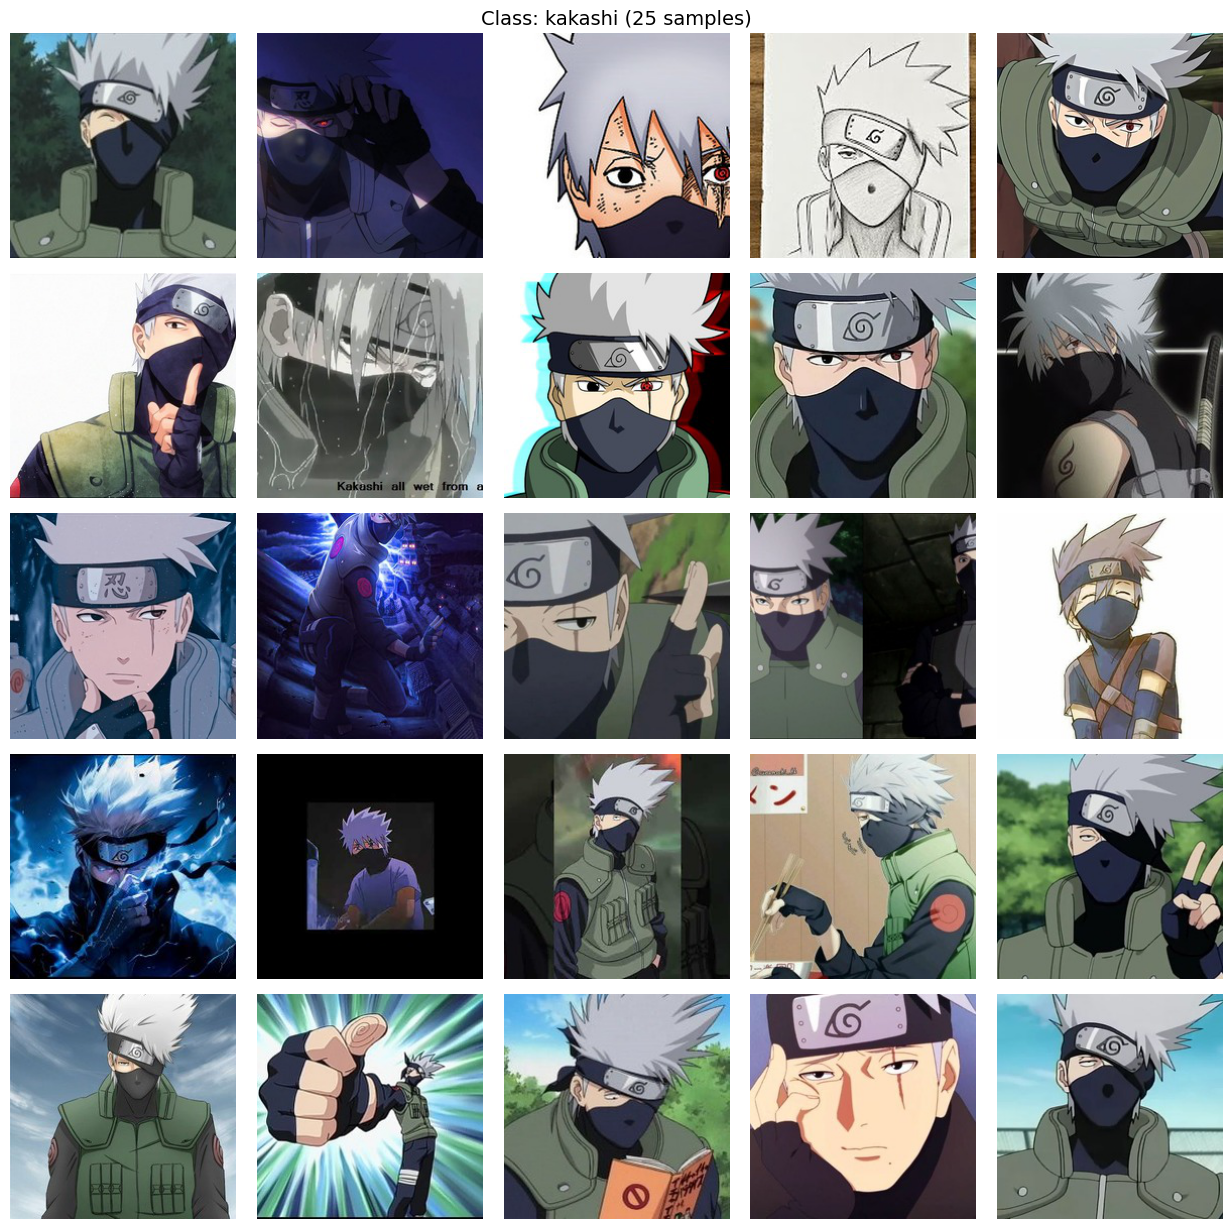

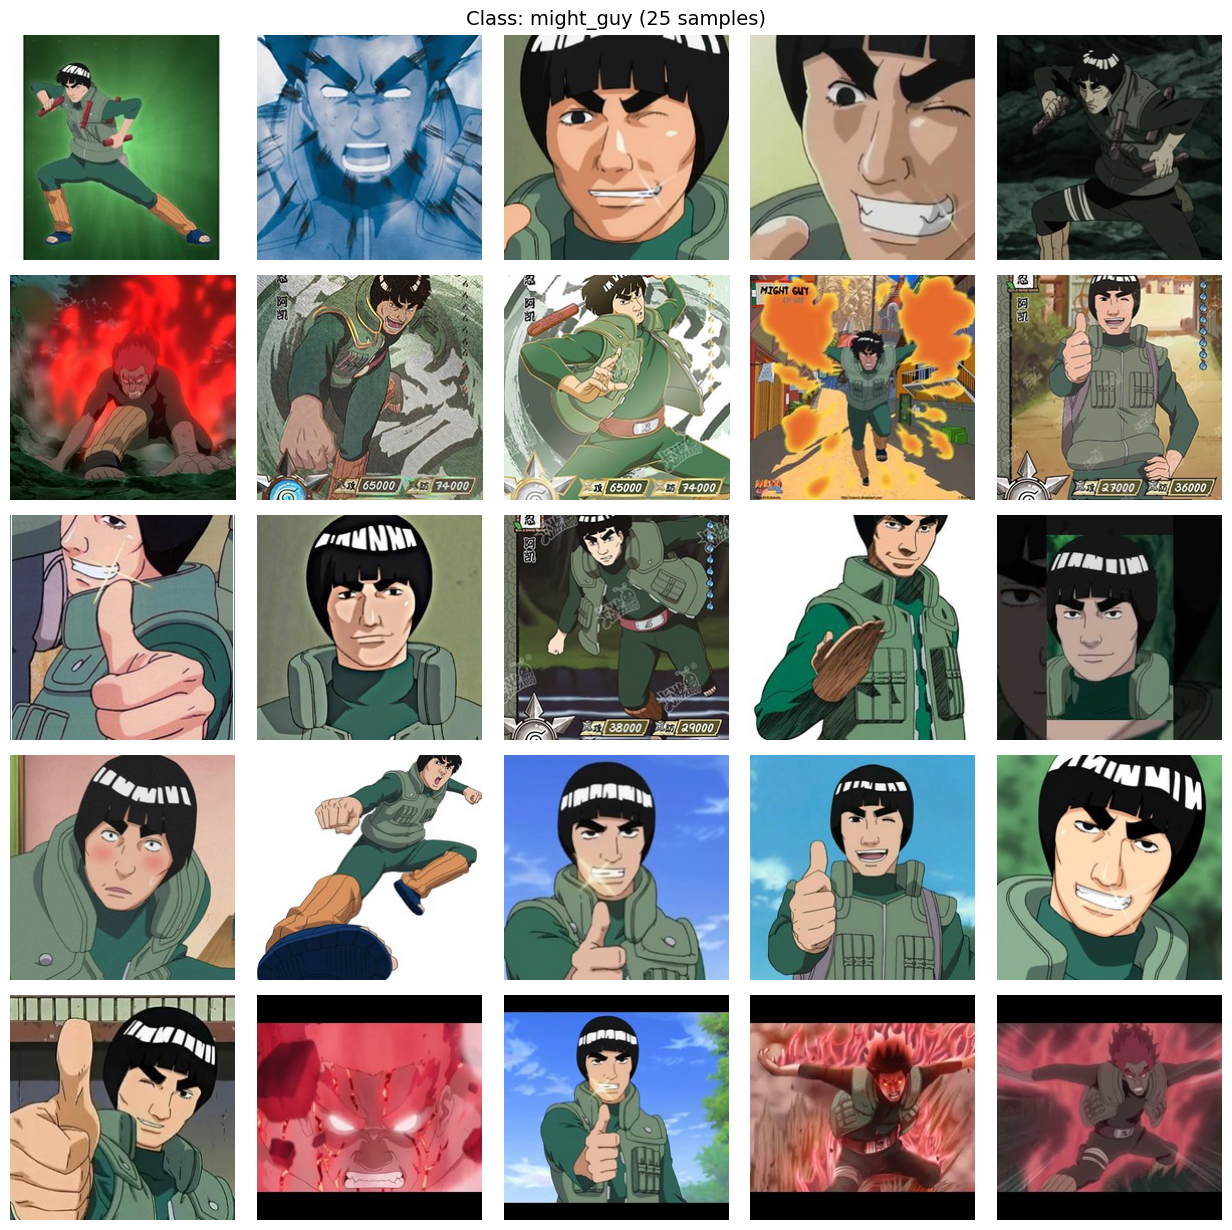

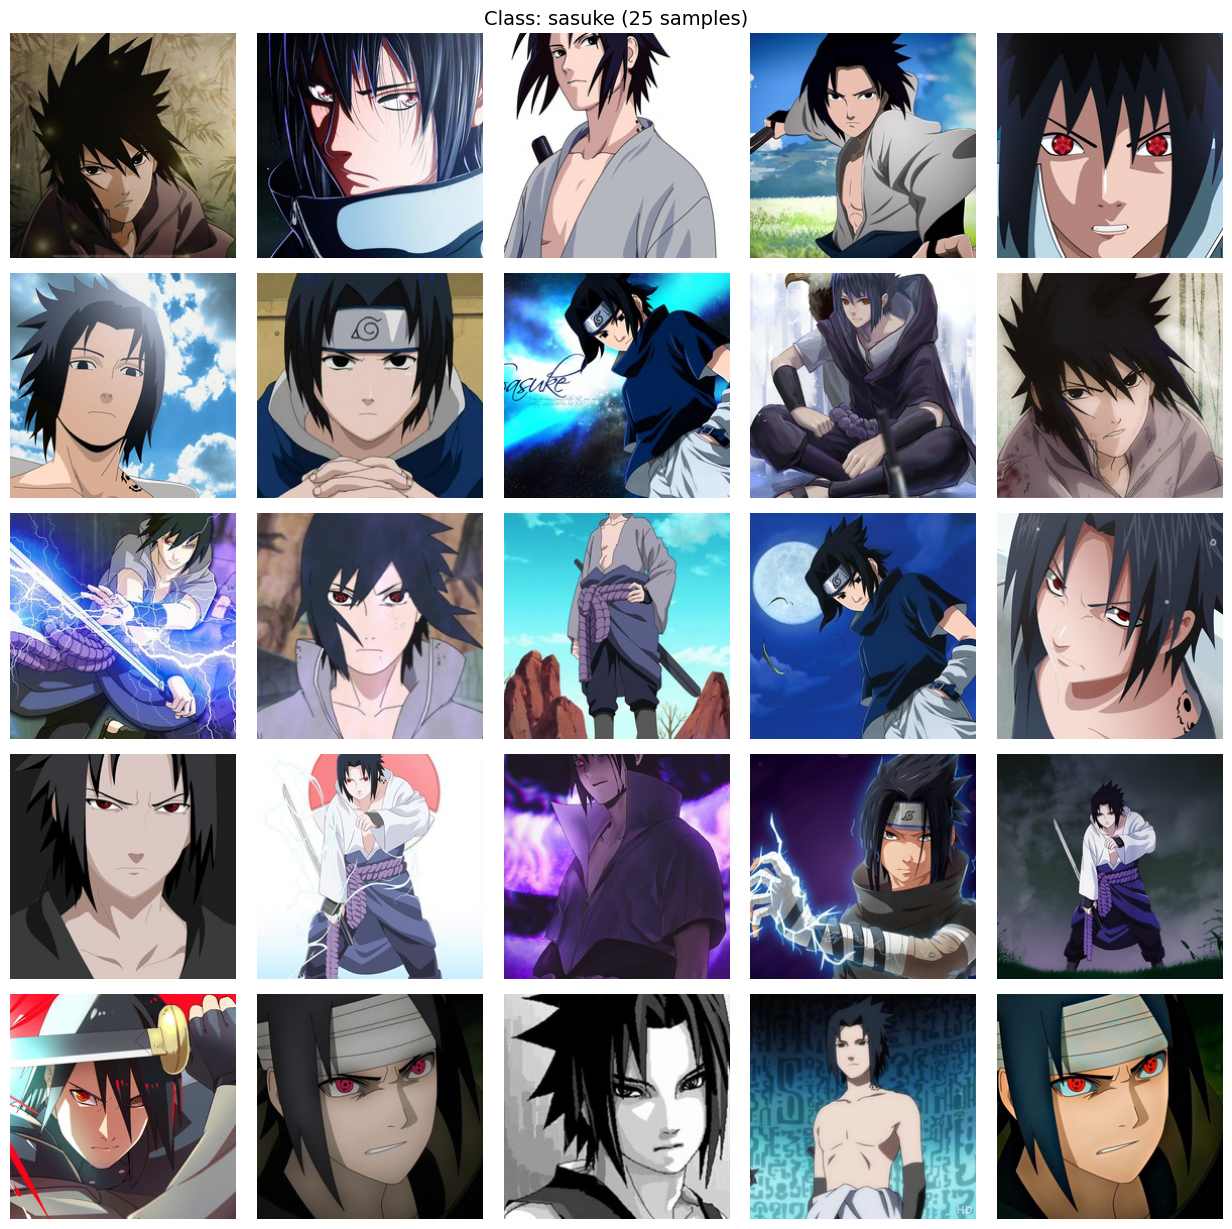

In [47]:
def show_grid(class_name: str, n: int = 25, cols: int = 5):
    class_dir = DATA_DIR / class_name
    assert class_dir.exists(), f"Class folder not found: {class_dir}"

    paths = sorted(class_dir.glob("*.jpg"))[:n]
    if not paths:
        print(f"No images found for class '{class_name}'")
        return

    rows = math.ceil(len(paths) / cols)
    plt.figure(figsize=(cols * 2.5, rows * 2.5))

    for i, p in enumerate(paths, 1):
        with Image.open(p) as img:
            ax = plt.subplot(rows, cols, i)
            ax.imshow(img)
            ax.axis("off")

    plt.suptitle(f"Class: {class_name} ({len(paths)} samples)", fontsize=14)
    plt.tight_layout()
    plt.show()


# Class examples
for c in classes:
    show_grid(c, n=25, cols=5)


# Prepear train/val and augmentation

In [50]:
from torch.utils.data import Subset

ds_train = datasets.ImageFolder(DATA_DIR, transform=train_tfms)
ds_val   = datasets.ImageFolder(DATA_DIR, transform=val_tfms)

class_to_idx = ds_train.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)
print("classes:", class_to_idx)

g = torch.Generator().manual_seed(SEED)
n = len(ds_train)
n_val = int(VAL_FRAC * n)
perm = torch.randperm(n, generator=g).tolist()
val_idx = perm[:n_val]
train_idx = perm[n_val:]

train_ds = Subset(ds_train, train_idx)
val_ds   = Subset(ds_val, val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("split:", len(train_ds), len(val_ds))


classes: {'kakashi': 0, 'might_guy': 1, 'sasuke': 2}
split: 212 52


# Fine-tuning model №1 resnet18

In [54]:
def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    all_preds, all_targets = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

        all_preds.append(pred.detach().cpu())
        all_targets.append(y.detach().cpu())

    if total == 0:
        return float("nan"), float("nan"), None, None

    avg_loss = total_loss / total
    avg_acc = correct / total
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    return avg_loss, avg_acc, all_preds, all_targets


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    if total == 0:
        return float("nan"), float("nan")

    avg_loss = total_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc


In [64]:
def freeze_backbone(model, unfreeze_keys=("fc.", "classifier.", "head.")):
    """
    Freezes all model parameters and unfreezes only the classifier.
    """
    for p in model.parameters():
        p.requires_grad = False

    unfrozen_names = []
    for name, p in model.named_parameters():
        if name.startswith(unfreeze_keys):
            p.requires_grad = True
            unfrozen_names.append(name)

    return unfrozen_names


# ===== Model: ResNet18 =====
model_name = "resnet18"
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes).to(device)

unfrozen = freeze_backbone(model)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print(f"Model: {model_name}")
print(f"Trainable params: {trainable:,} / {total:,}")
print("Unfrozen layers:", unfrozen)


Model: resnet18
Trainable params: 1,539 / 11,178,051
Unfrozen layers: ['fc.weight', 'fc.bias']


In [65]:
def run_stage(model, train_loader, val_loader, optimizer, criterion, device, epochs, history, prefix, best_state):
    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device=device)
        va_loss, va_acc, _, _ = evaluate(model, val_loader, criterion, device=device)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        if va_acc > best_state["best_acc"]:
            best_state["best_acc"] = va_acc
            torch.save(model.state_dict(), best_state["path"])

        lr = optimizer.param_groups[0]["lr"]
        print(f"[{prefix}][{epoch}/{epochs}] lr={lr:.1e} "
              f"train loss={tr_loss:.4f} acc={tr_acc:.3f} | "
              f"val loss={va_loss:.4f} acc={va_acc:.3f} | best={best_state['best_acc']:.3f}")
        
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    (p for p in model.parameters() if p.requires_grad),
    lr=3e-4,
    weight_decay=1e-4
)

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_state = {"best_acc": -1.0, "path": "best_resnet18.pth"}

run_stage(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=3,
    history=history,
    prefix="ResNet18 Stage1",
    best_state=best_state
)


[ResNet18 Stage1][1/3] lr=3.0e-04 train loss=1.0873 acc=0.330 | val loss=1.0489 acc=0.481 | best=0.481
[ResNet18 Stage1][2/3] lr=3.0e-04 train loss=1.0658 acc=0.410 | val loss=1.0410 acc=0.538 | best=0.538
[ResNet18 Stage1][3/3] lr=3.0e-04 train loss=1.0522 acc=0.519 | val loss=1.0305 acc=0.577 | best=0.577


In [66]:
# unfreeze all
for p in model.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

EPOCHS_STAGE2 = 6

best_val_acc = max(history["val_acc"]) if history["val_acc"] else -1.0
best_path = f"best_{model_name}.pth"

for epoch in range(1, EPOCHS_STAGE2 + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device=device)
    va_loss, va_acc, _, _ = evaluate(model, val_loader, criterion, device=device)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), best_path)

    lr = optimizer.param_groups[0]["lr"]
    print(f"[Stage2][{epoch}/{EPOCHS_STAGE2}] lr={lr:.1e} "
          f"train loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val loss={va_loss:.4f} acc={va_acc:.3f} | best={best_val_acc:.3f}")


[Stage2][1/6] lr=1.0e-04 train loss=1.0276 acc=0.642 | val loss=1.0012 acc=0.712 | best=0.712
[Stage2][2/6] lr=1.0e-04 train loss=0.9778 acc=0.774 | val loss=0.9645 acc=0.750 | best=0.750
[Stage2][3/6] lr=1.0e-04 train loss=0.9465 acc=0.807 | val loss=0.9351 acc=0.808 | best=0.808
[Stage2][4/6] lr=1.0e-04 train loss=0.8942 acc=0.863 | val loss=0.8909 acc=0.846 | best=0.846
[Stage2][5/6] lr=1.0e-04 train loss=0.8463 acc=0.915 | val loss=0.8470 acc=0.904 | best=0.904
[Stage2][6/6] lr=1.0e-04 train loss=0.7829 acc=0.943 | val loss=0.7976 acc=0.923 | best=0.923


In [71]:
def plot_history(history, title_prefix):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss curves ({title_prefix})")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs, history["train_acc"], label="train accuracy")
    plt.plot(epochs, history["val_acc"], label="val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy curves ({title_prefix})")
    plt.legend()
    plt.grid(True)
    plt.show()

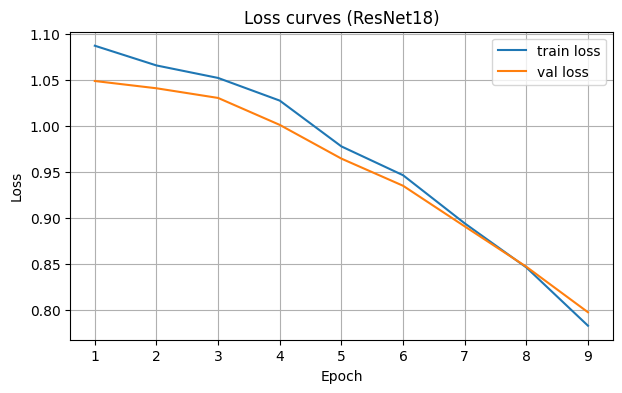

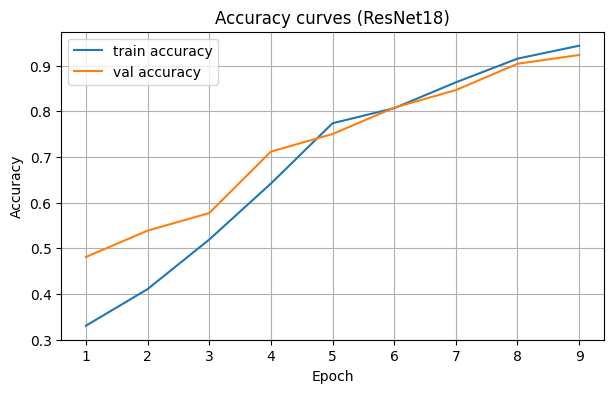

In [72]:
plot_history(history, "ResNet18")

Best ResNet18 val acc: 0.9231


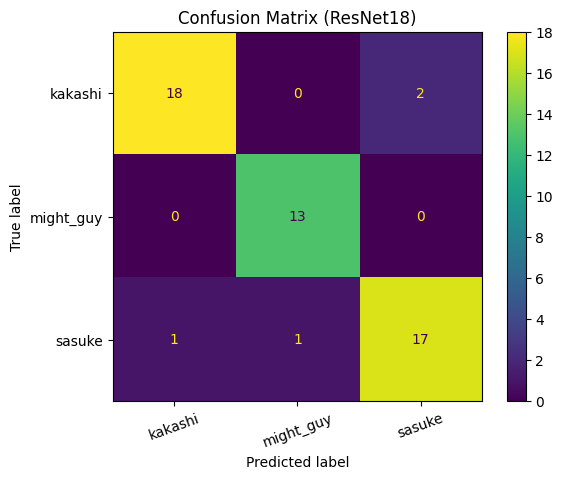

In [73]:
def load_model(model_name: str, ckpt_path: str, num_classes: int, device: str):
    m = timm.create_model(model_name, pretrained=False, num_classes=num_classes).to(device)
    state = torch.load(ckpt_path, map_location=device, weights_only=True)
    m.load_state_dict(state)
    m.eval()
    return m

def plot_confusion(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(values_format="d")
    plt.xticks(rotation=20)
    plt.title(title)
    plt.show()

best_model = load_model("resnet18", "best_resnet18.pth", num_classes, device)

val_loss, val_acc, y_pred, y_true = evaluate(best_model, val_loader, nn.CrossEntropyLoss(), device=device)
print(f"Best ResNet18 val acc: {val_acc:.4f}")

labels = [idx_to_class[i] for i in range(num_classes)]
plot_confusion(y_true, y_pred, labels, "Confusion Matrix (ResNet18)")


# Fine-tuning model №2 ConvNeXt Tiny

In [74]:
model2_name = "convnext_tiny"
model2 = timm.create_model(model2_name, pretrained=True, num_classes=num_classes).to(device)

unfrozen = freeze_backbone(
    model2,
    unfreeze_keys=("head.", "classifier.", "fc.", "final.")
)

trainable2 = sum(p.numel() for p in model2.parameters() if p.requires_grad)
total2 = sum(p.numel() for p in model2.parameters())

print(f"Model: {model2_name}")
print(f"Trainable params: {trainable2:,} / {total2:,}")
print("Unfrozen layers:", unfrozen[:10], "..." if len(unfrozen) > 10 else "")


Model: convnext_tiny
Trainable params: 3,843 / 27,822,435
Unfrozen layers: ['head.norm.weight', 'head.norm.bias', 'head.fc.weight', 'head.fc.bias'] 


In [75]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.AdamW(
    (p for p in model2.parameters() if p.requires_grad),
    lr=3e-4,
    weight_decay=1e-4
)

EPOCHS2_STAGE1 = 3
history2 = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS2_STAGE1 + 1):
    tr_loss, tr_acc = train_one_epoch(model2, train_loader, optimizer2, criterion2, device=device)
    va_loss, va_acc, _, _ = evaluate(model2, val_loader, criterion2, device=device)

    history2["train_loss"].append(tr_loss)
    history2["train_acc"].append(tr_acc)
    history2["val_loss"].append(va_loss)
    history2["val_acc"].append(va_acc)

    lr = optimizer2.param_groups[0]["lr"]
    print(f"[ConvNeXt Stage1][{epoch}/{EPOCHS2_STAGE1}] lr={lr:.1e} "
          f"train loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val loss={va_loss:.4f} acc={va_acc:.3f}")


[ConvNeXt Stage1][1/3] lr=3.0e-04 train loss=1.3314 acc=0.316 | val loss=1.1660 acc=0.404
[ConvNeXt Stage1][2/3] lr=3.0e-04 train loss=1.0454 acc=0.495 | val loss=1.1216 acc=0.462
[ConvNeXt Stage1][3/3] lr=3.0e-04 train loss=0.9333 acc=0.580 | val loss=0.9189 acc=0.654


In [76]:
# unfreeze all
for p in model2.parameters():
    p.requires_grad = True

optimizer2 = torch.optim.AdamW(model2.parameters(), lr=1e-4, weight_decay=1e-4)

EPOCHS2_STAGE2 = 6
best_val_acc2 = max(history2["val_acc"]) if history2["val_acc"] else -1.0
best_path2 = f"best_{model2_name}.pth"

for epoch in range(1, EPOCHS2_STAGE2 + 1):
    tr_loss, tr_acc = train_one_epoch(model2, train_loader, optimizer2, criterion2, device=device)
    va_loss, va_acc, _, _ = evaluate(model2, val_loader, criterion2, device=device)

    history2["train_loss"].append(tr_loss)
    history2["train_acc"].append(tr_acc)
    history2["val_loss"].append(va_loss)
    history2["val_acc"].append(va_acc)

    if va_acc > best_val_acc2:
        best_val_acc2 = va_acc
        torch.save(model2.state_dict(), best_path2)

    lr = optimizer2.param_groups[0]["lr"]
    print(f"[ConvNeXt Stage2][{epoch}/{EPOCHS2_STAGE2}] lr={lr:.1e} "
          f"train loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val loss={va_loss:.4f} acc={va_acc:.3f} | best={best_val_acc2:.3f}")


[ConvNeXt Stage2][1/6] lr=1.0e-04 train loss=1.3865 acc=0.566 | val loss=0.7552 acc=0.577 | best=0.654
[ConvNeXt Stage2][2/6] lr=1.0e-04 train loss=0.3225 acc=0.873 | val loss=0.1231 acc=0.962 | best=0.962
[ConvNeXt Stage2][3/6] lr=1.0e-04 train loss=0.0676 acc=0.972 | val loss=0.0519 acc=0.981 | best=0.981
[ConvNeXt Stage2][4/6] lr=1.0e-04 train loss=0.0157 acc=1.000 | val loss=0.1281 acc=0.942 | best=0.981
[ConvNeXt Stage2][5/6] lr=1.0e-04 train loss=0.0050 acc=1.000 | val loss=0.0706 acc=0.962 | best=0.981
[ConvNeXt Stage2][6/6] lr=1.0e-04 train loss=0.0035 acc=1.000 | val loss=0.0658 acc=0.981 | best=0.981


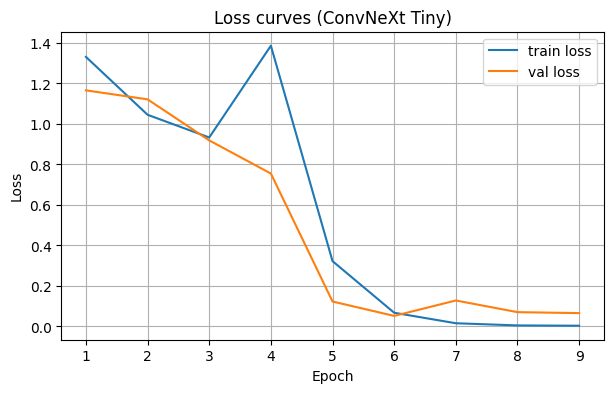

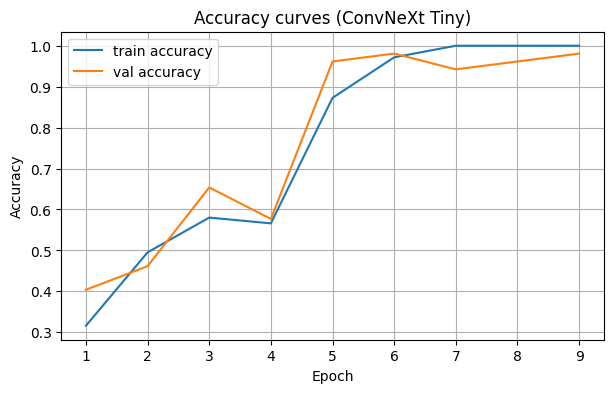

In [77]:
plot_history(history2, "ConvNeXt Tiny")

Best ConvNeXt Tiny val acc: 0.9808


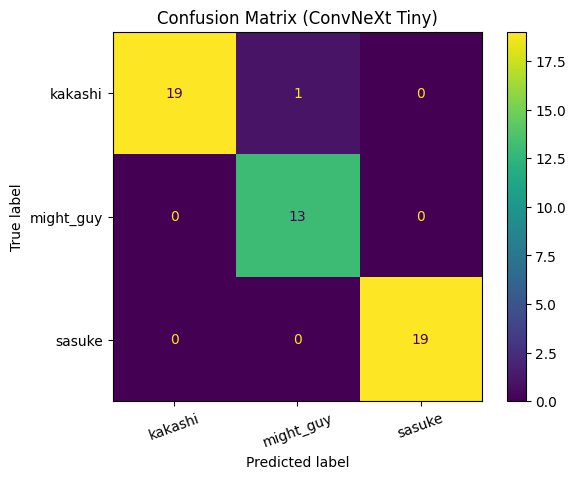

In [78]:
best_model2 = timm.create_model(
    model2_name,
    pretrained=False,
    num_classes=num_classes
).to(device)

best_model2.load_state_dict(
    torch.load(best_path2, map_location=device, weights_only=True)
)
best_model2.eval()

val_loss2, val_acc2, y_pred2, y_true2 = evaluate(
    best_model2, val_loader, criterion2, device=device
)

print(f"Best ConvNeXt Tiny val acc: {val_acc2:.4f}")

labels = [idx_to_class[i] for i in range(num_classes)]
plot_confusion(
    y_true2,
    y_pred2,
    labels,
    "Confusion Matrix (ConvNeXt Tiny)"
)


# Export model

In [79]:
from pathlib import Path

best_onnx_path = f"best_{model2_name}.onnx"

# грузим лучшую модель на CPU
onnx_model = timm.create_model(model2_name, pretrained=False, num_classes=num_classes)
state = torch.load(best_path2, map_location="cpu", weights_only=True)
onnx_model.load_state_dict(state)
onnx_model.eval()

dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

torch.onnx.export(
    onnx_model,
    dummy,
    best_onnx_path,
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
    opset_version=17
)

print("Saved ONNX:", best_onnx_path)
print("File exists:", Path(best_onnx_path).exists())


Saved ONNX: best_convnext_tiny.onnx
File exists: True


# Testing model on test dataset

External test size: 25
External test classes: {'kakashi': 0, 'might_guy': 1, 'sasuke': 2}
External test accuracy: 1.0000


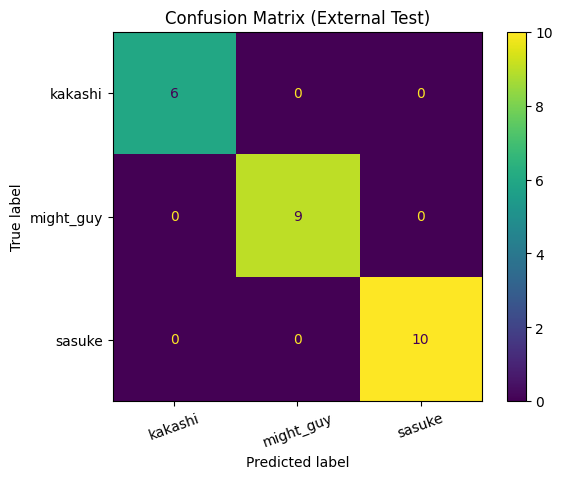

In [80]:
TEST_DIR = Path("data/external_test")
assert TEST_DIR.exists(), f"TEST_DIR not found: {TEST_DIR.resolve()}"

test_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

test_ds = datasets.ImageFolder(TEST_DIR, transform=test_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

print("External test size:", len(test_ds))
print("External test classes:", test_ds.class_to_idx)

# ВАЖНО: порядок классов должен совпадать с train
train_classes = [idx_to_class[i] for i in range(num_classes)]
test_classes = list(test_ds.class_to_idx.keys())

assert train_classes == test_classes, (
    "Class order mismatch!\n"
    f"train: {train_classes}\n"
    f"test : {test_classes}\n"
    "Fix by renaming folders in data/external_test to match training classes."
)

# Загружаем лучшую модель (ConvNeXt)
best_model_ext = timm.create_model(model2_name, pretrained=False, num_classes=num_classes).to(device)
best_model_ext.load_state_dict(torch.load(best_path2, map_location=device, weights_only=True))
best_model_ext.eval()

val_loss_ext, acc_ext, y_pred_ext, y_true_ext = evaluate(
    best_model_ext, test_loader, nn.CrossEntropyLoss(), device=device
)

print(f"External test accuracy: {acc_ext:.4f}")

labels = train_classes
cm = confusion_matrix(y_true_ext, y_pred_ext)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(values_format="d")
plt.xticks(rotation=20)
plt.title("Confusion Matrix (External Test)")
plt.show()


# Testing on one photo (if nedeed)

In [81]:
def predict_image(
    img_path,
    model,
    transform,
    idx_to_class,
    device
):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    pred_idx = probs.argmax()
    pred_class = idx_to_class[pred_idx]

    prob_dict = {
        idx_to_class[i]: float(probs[i])
        for i in range(len(probs))
    }
    prob_dict = dict(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True))

    return pred_class, prob_dict, img


Prediction: kakashi
Probabilities:
  kakashi   : 0.5229
  sasuke    : 0.2620
  might_guy : 0.2151


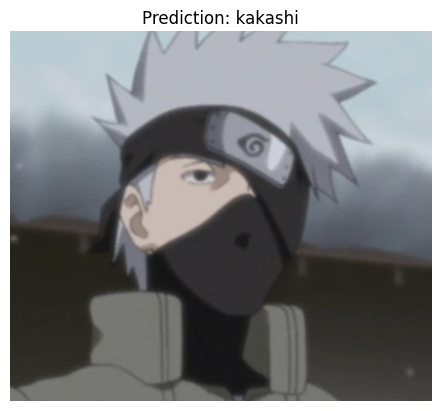

In [82]:
model.eval()

pred, probs, img = predict_image(
    "data/single_test.jpg",
    model,
    tfm,
    idx_to_class,
    device
)

print("Prediction:", pred)
print("Probabilities:")
for k, v in probs.items():
    print(f"  {k:10s}: {v:.4f}")

plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {pred}")
plt.show()
